In [40]:
import json
from glob import glob
import numpy as np
from PIL import Image, ImageOps
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
import tensorflow as tf
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from deepface import DeepFace

In [3]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [4]:
SUPPORT_IMAGES_PATH = "./DemoDataset/support_images"
PHOTOS_PATH = "./DemoDataset/photos_dataset"
PHOTOS_LABELS_PATH = "./DemoDataset/photos_dataset_labels.json"

In [5]:
# load support images. Add to dictionary
support_images_files = glob(f"{SUPPORT_IMAGES_PATH}/*.jpeg")
support_images = {Path(path).stem: Image.open(path) for path in support_images_files}
support_images

{'alina': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x641>,
 'anner': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x641>,
 'diana': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'shai': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>}

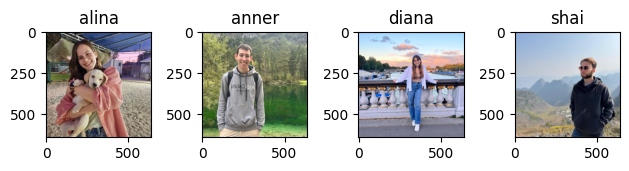

In [6]:
# plot all support images with the names
fig, ax = plt.subplots(1, 4)
fig.patch.set_facecolor('white')
for i, (name, image) in enumerate(support_images.items()):
    ax[i].imshow(image)
    ax[i].set_title(name)
plt.tight_layout()
plt.show()

In [7]:
# load dataset images and the labels json
photos_files = glob(f"{PHOTOS_PATH}/*.jpeg") + glob(f"{PHOTOS_LABELS_PATH}/*.jpg")
# load json
photos_labels = json.load(open(PHOTOS_LABELS_PATH))
photos_labels_res = {k + ".jpeg" if k + ".jpeg" in os.listdir(PHOTOS_PATH) else k + ".jpg": [vv.lower() for vv in v] for k, v in photos_labels.items()}
photos_labels_res

{'1.jpeg': ['alina', 'shai'],
 '2.jpeg': ['shai'],
 '3.jpg': ['diana', 'anner', 'shai', 'alina'],
 '4.jpeg': ['shai'],
 '5.jpg': ['alina', 'diana'],
 '6.jpeg': ['shai'],
 '7.jpeg': ['alina'],
 '8.jpeg': ['diana'],
 '9.jpg': ['alina'],
 '10.jpg': ['shai', 'alina'],
 '11.jpeg': ['diana'],
 '12.jpg': ['alina'],
 '13.jpeg': ['shai', 'alina'],
 '14.jpeg': ['alina', 'shai', 'anner', 'diana'],
 '15.jpeg': ['alina'],
 '16.jpeg': ['anner'],
 '17.jpg': ['diana', 'alina', 'anner'],
 '18.jpeg': ['alina', 'shai', 'anner', 'diana'],
 '19.jpeg': ['shai'],
 '20.jpg': ['alina']}

In [8]:
photos_labels_dict = {os.path.join(PHOTOS_PATH, path) : lbl for path, lbl in photos_labels_res.items()}
photos_labels_dict

{'./DemoDataset/photos_dataset\\1.jpeg': ['alina', 'shai'],
 './DemoDataset/photos_dataset\\2.jpeg': ['shai'],
 './DemoDataset/photos_dataset\\3.jpg': ['diana', 'anner', 'shai', 'alina'],
 './DemoDataset/photos_dataset\\4.jpeg': ['shai'],
 './DemoDataset/photos_dataset\\5.jpg': ['alina', 'diana'],
 './DemoDataset/photos_dataset\\6.jpeg': ['shai'],
 './DemoDataset/photos_dataset\\7.jpeg': ['alina'],
 './DemoDataset/photos_dataset\\8.jpeg': ['diana'],
 './DemoDataset/photos_dataset\\9.jpg': ['alina'],
 './DemoDataset/photos_dataset\\10.jpg': ['shai', 'alina'],
 './DemoDataset/photos_dataset\\11.jpeg': ['diana'],
 './DemoDataset/photos_dataset\\12.jpg': ['alina'],
 './DemoDataset/photos_dataset\\13.jpeg': ['shai', 'alina'],
 './DemoDataset/photos_dataset\\14.jpeg': ['alina', 'shai', 'anner', 'diana'],
 './DemoDataset/photos_dataset\\15.jpeg': ['alina'],
 './DemoDataset/photos_dataset\\16.jpeg': ['anner'],
 './DemoDataset/photos_dataset\\17.jpg': ['diana', 'alina', 'anner'],
 './DemoDatase

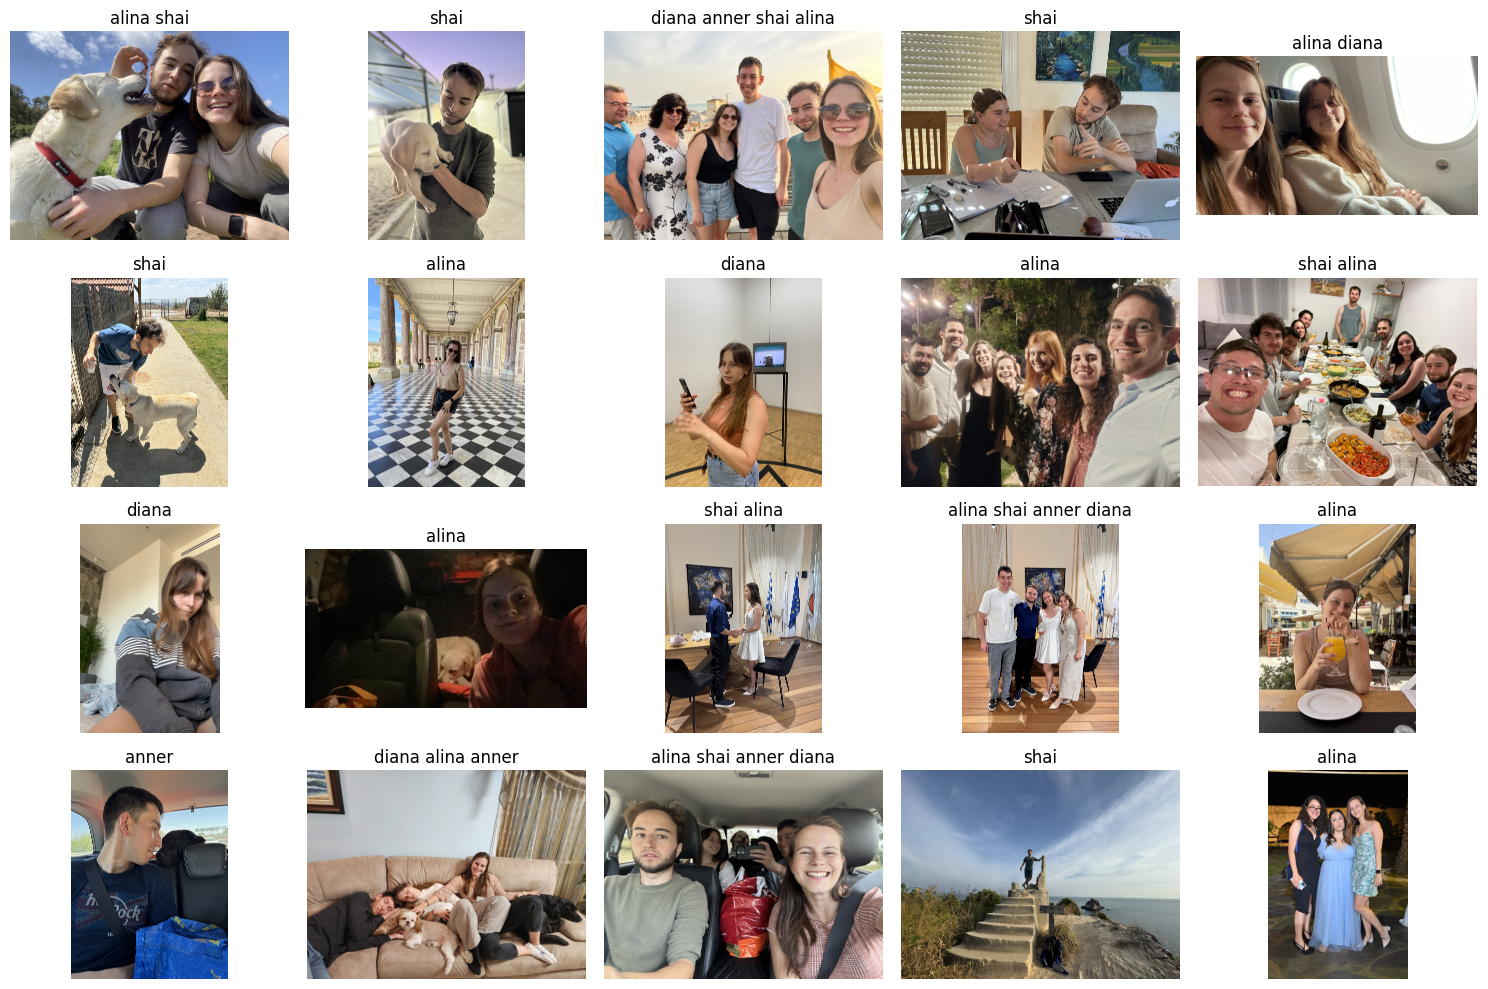

In [9]:
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
fig.patch.set_facecolor('white')
ax = ax.flatten()
# plot all photos with labels as titles
for i, (image, labels) in enumerate(photos_labels_dict.items()):
    img = Image.open(image)
    img = ImageOps.exif_transpose(img)
    ax[i].imshow(np.array(img))
    ax[i].set_title(" ".join(labels))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect("equal")
    ax[i].set_axis_off()
plt.tight_layout()
plt.show()

Now, we have loaded all of the images and their labels and the support images, let's investigate for a good on-shot face recognition model.

Appearantly DeepFace is a wholesome package for face detection, matching, analysis, everything, so we are gonna use that in our research! Let's measure it's accuracy (in terms of recall and precision) for each of the persons images inside the support set. 

In [10]:
photos_labels_dict

{'./DemoDataset/photos_dataset\\1.jpeg': ['alina', 'shai'],
 './DemoDataset/photos_dataset\\2.jpeg': ['shai'],
 './DemoDataset/photos_dataset\\3.jpg': ['diana', 'anner', 'shai', 'alina'],
 './DemoDataset/photos_dataset\\4.jpeg': ['shai'],
 './DemoDataset/photos_dataset\\5.jpg': ['alina', 'diana'],
 './DemoDataset/photos_dataset\\6.jpeg': ['shai'],
 './DemoDataset/photos_dataset\\7.jpeg': ['alina'],
 './DemoDataset/photos_dataset\\8.jpeg': ['diana'],
 './DemoDataset/photos_dataset\\9.jpg': ['alina'],
 './DemoDataset/photos_dataset\\10.jpg': ['shai', 'alina'],
 './DemoDataset/photos_dataset\\11.jpeg': ['diana'],
 './DemoDataset/photos_dataset\\12.jpg': ['alina'],
 './DemoDataset/photos_dataset\\13.jpeg': ['shai', 'alina'],
 './DemoDataset/photos_dataset\\14.jpeg': ['alina', 'shai', 'anner', 'diana'],
 './DemoDataset/photos_dataset\\15.jpeg': ['alina'],
 './DemoDataset/photos_dataset\\16.jpeg': ['anner'],
 './DemoDataset/photos_dataset\\17.jpg': ['diana', 'alina', 'anner'],
 './DemoDatase

In [11]:
labels_photos_dict = {}
for path, labels in photos_labels_dict.items():
    for label in labels:
        if label not in labels_photos_dict:
            labels_photos_dict[label] = []
        labels_photos_dict[label].append(path)
print({k: len(labels_photos_dict[k]) for k in labels_photos_dict.keys()})

{'alina': 13, 'shai': 10, 'diana': 7, 'anner': 5}


In [12]:
dfs_alina = DeepFace.find(img_path=".\\DemoDataset\\support_images\\alina.jpeg", db_path=PHOTOS_PATH, model_name="Facenet", detector_backend="mtcnn")
dfs_alina

25-07-13 16:11:34 - Searching .\DemoDataset\support_images\alina.jpeg in 46 length datastore
25-07-13 16:11:40 - find function duration 5.496086835861206 seconds


[                               identity  \
 0  ./DemoDataset/photos_dataset\14.jpeg   
 1   ./DemoDataset/photos_dataset\17.jpg   
 2   ./DemoDataset/photos_dataset\20.jpg   
 
                                        hash  target_x  target_y  target_w  \
 0  11126de605f09d3fac89ec022f2522e055855880      1784      1512       215   
 1  62ddaf058fd8129ac6cd91ecabe6d747440fafe2       948       498        79   
 2  e3cf51277d60b34735a2e58900058111a345ae8e       627       238       105   
 
    target_h  source_x  source_y  source_w  source_h  threshold  distance  
 0       277       183        89       112       144        0.4  0.263557  
 1       101       183        89       112       144        0.4  0.333623  
 2       130       183        89       112       144        0.4  0.340229  ]

In [13]:
dfs_diana = DeepFace.find(img_path=".\\DemoDataset\\support_images\\diana.jpeg", db_path=PHOTOS_PATH, model_name="Facenet", detector_backend="mtcnn")
dfs_diana

25-07-13 16:11:40 - Searching .\DemoDataset\support_images\diana.jpeg in 46 length datastore
25-07-13 16:11:40 - find function duration 0.6560931205749512 seconds


[                               identity  \
 0  ./DemoDataset/photos_dataset\14.jpeg   
 1   ./DemoDataset/photos_dataset\8.jpeg   
 2   ./DemoDataset/photos_dataset\8.jpeg   
 3    ./DemoDataset/photos_dataset\3.jpg   
 4  ./DemoDataset/photos_dataset\11.jpeg   
 
                                        hash  target_x  target_y  target_w  \
 0  11126de605f09d3fac89ec022f2522e055855880      2151      1594       218   
 1  53277b40916c35065f5e50a5f472f9bb21e439ae      1068      1414       434   
 2  53277b40916c35065f5e50a5f472f9bb21e439ae      1899      1534        51   
 3  c55405ba53a471f1d849853e82cf56fcff39c2f1       854       571       124   
 4  5322521dd94f6585af60ac30e723699512369b2c       823       474       305   
 
    target_h  source_x  source_y  source_w  source_h  threshold  distance  
 0       292       335       159        41        51        0.4  0.170111  
 1       626       335       159        41        51        0.4  0.270684  
 2        76       335       159    

In [14]:
dfs_shai = DeepFace.find(img_path=".\\DemoDataset\\support_images\\shai.jpeg", db_path=PHOTOS_PATH, model_name="Facenet", detector_backend="mtcnn")
dfs_shai

25-07-13 16:11:41 - Searching .\DemoDataset\support_images\shai.jpeg in 46 length datastore
25-07-13 16:11:41 - find function duration 0.6404714584350586 seconds


[Empty DataFrame
 Columns: [identity, hash, target_x, target_y, target_w, target_h, source_x, source_y, source_w, source_h, threshold, distance]
 Index: []]

In [15]:
dfs_anner = DeepFace.find(img_path=".\\DemoDataset\\support_images\\anner.jpeg", db_path=PHOTOS_PATH, model_name="Facenet", detector_backend="mtcnn")
dfs_anner

25-07-13 16:11:41 - Searching .\DemoDataset\support_images\anner.jpeg in 46 length datastore
25-07-13 16:11:42 - find function duration 0.6404709815979004 seconds


[                               identity  \
 0    ./DemoDataset/photos_dataset\3.jpg   
 1  ./DemoDataset/photos_dataset\14.jpeg   
 
                                        hash  target_x  target_y  target_w  \
 0  c55405ba53a471f1d849853e82cf56fcff39c2f1       986       252       153   
 1  11126de605f09d3fac89ec022f2522e055855880       823      1035       286   
 
    target_h  source_x  source_y  source_w  source_h  threshold  distance  
 0       220       214       107        80       113        0.4  0.125397  
 1       418       214       107        80       113        0.4  0.161306  ]

Let's check the results for face matching with Facenet and mtcnn detector with default threshold 0.4:

In [20]:
alina_preds

0    ./DemoDataset/photos_dataset\14.jpeg
1     ./DemoDataset/photos_dataset\17.jpg
2     ./DemoDataset/photos_dataset\20.jpg
Name: identity, dtype: object

In [21]:
labels_photos_dict["alina"]

['./DemoDataset/photos_dataset\\1.jpeg',
 './DemoDataset/photos_dataset\\3.jpg',
 './DemoDataset/photos_dataset\\5.jpg',
 './DemoDataset/photos_dataset\\7.jpeg',
 './DemoDataset/photos_dataset\\9.jpg',
 './DemoDataset/photos_dataset\\10.jpg',
 './DemoDataset/photos_dataset\\12.jpg',
 './DemoDataset/photos_dataset\\13.jpeg',
 './DemoDataset/photos_dataset\\14.jpeg',
 './DemoDataset/photos_dataset\\15.jpeg',
 './DemoDataset/photos_dataset\\17.jpg',
 './DemoDataset/photos_dataset\\18.jpeg',
 './DemoDataset/photos_dataset\\20.jpg']

In [38]:
# measure accuracy, precision, recall, f1-score
def calculate_metrics(preds, labels):
    labels = [Path(label).stem for label in labels]
    preds = [Path(pred).stem for pred in preds]
    # Create binary labels for true and predicted
    y_true = [1 if str(i+1) in labels else 0 for i in range(len(photos_labels_dict))]
    y_pred = [1 if str(i+1) in preds else 0 for i in range(len(photos_labels_dict))]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1



In [41]:
# create a DF to holds metrics for each person
metrics_df = {
    "name": [],
    "accuracy": [], 
    "precision": [],
    "recall": [],
    "f1_score": []
}

# Calculate metrics for Alina's predictions
alina_preds = dfs_alina[0]["identity"]
accuracy, precision, recall, f1 = calculate_metrics(alina_preds, labels_photos_dict["alina"])
metrics_df["name"].append("Alina")
metrics_df["accuracy"].append(accuracy) 
metrics_df["precision"].append(precision)
metrics_df["recall"].append(recall)
metrics_df["f1_score"].append(f1)

# Calculate metrics for Diana's predictions
diana_preds = dfs_diana[0]["identity"]
accuracy, precision, recall, f1 = calculate_metrics(diana_preds, labels_photos_dict["diana"])
metrics_df["name"].append("Diana")
metrics_df["accuracy"].append(accuracy)
metrics_df["precision"].append(precision)
metrics_df["recall"].append(recall)
metrics_df["f1_score"].append(f1)

# Calculate metrics for Shai's predictions
shai_preds = dfs_shai[0]["identity"]
accuracy, precision, recall, f1 = calculate_metrics(shai_preds, labels_photos_dict["shai"])
metrics_df["name"].append("Shai")
metrics_df["accuracy"].append(accuracy)
metrics_df["precision"].append(precision)
metrics_df["recall"].append(recall)
metrics_df["f1_score"].append(f1)

# Calculate metrics for Anner's predictions
anner_preds = dfs_anner[0]["identity"]             
accuracy, precision, recall, f1 = calculate_metrics(anner_preds, labels_photos_dict["anner"])
metrics_df["name"].append("Anner")
metrics_df["accuracy"].append(accuracy)
metrics_df["precision"].append(precision)
metrics_df["recall"].append(recall)
metrics_df["f1_score"].append(f1)

# Print the metrics DataFrame
metrics_df = pd.DataFrame(metrics_df)   
print(metrics_df)

    name  accuracy  precision    recall  f1_score
0  Alina      0.50        1.0  0.230769  0.375000
1  Diana      0.85        1.0  0.571429  0.727273
2   Shai      0.50        0.0  0.000000  0.000000
3  Anner      0.85        1.0  0.400000  0.571429


In [53]:
 # Calculate average metrics across all predictions
average_metrics = metrics_df.mean(numeric_only=True)
average_metrics 

accuracy     0.675000
precision    0.750000
recall       0.300549
f1_score     0.418425
dtype: float64